In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import art
from dotenv import load_dotenv
import random
from openpipe.client import OpenPipe

load_dotenv()

op_client = OpenPipe()
print("OpenPipe client initialized")

random.seed(42)


api = art.UnslothAPI(wandb_project="agent-reinforcement-training")
model = await api.get_or_create_model(
    name="tic-tac-toe-007", base_model="Qwen/Qwen2.5-7B-Instruct"
)

OpenPipe client initialized


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 04-04 00:20:56 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.49.0. vLLM: 0.7.3.
   \\   /|    NVIDIA H100 PCIe. Num GPUs = 1. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-7b-instruct-unsloth-bnb-4bit with actual GPU utilization = 54.63%
Unsloth: Your GPU has CUDA compute capability 9.0 with VRAM = 79.1 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 32768. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 37.3

[W404 00:21:10.896572795 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 04-04 00:21:10 model_runner.py:1110] Starting to load model unsloth/qwen2.5-7b-instruct-unsloth-bnb-4bit...
INFO 04-04 00:21:11 loader.py:1089] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 04-04 00:21:11 weight_utils.py:254] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:01<00:01,  1.36s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.15it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.06it/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:01<00:01,  1.39s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.13it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.04it/s]



INFO 04-04 00:21:15 model_runner.py:1115] Loading model weights took 6.7252 GB
INFO 04-04 00:21:15 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 04-04 00:21:19 worker.py:267] Memory profiling takes 3.47 seconds
INFO 04-04 00:21:19 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.55) = 43.21GiB
INFO 04-04 00:21:19 worker.py:267] model weights take 6.73GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.72GiB; the rest of the memory reserved for KV Cache is 31.62GiB.
INFO 04-04 00:21:20 executor_base.py:111] # cuda blocks: 37007, # CPU blocks: 7021
INFO 04-04 00:21:20 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 18.07x
INFO 04-04 00:21:26 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error

Capturing CUDA graph shapes: 100%|██████████| 43/43 [00:35<00:00,  1.21it/s]


INFO 04-04 00:22:01 model_runner.py:1562] Graph capturing finished in 36 secs, took 0.96 GiB
INFO 04-04 00:22:01 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 45.71 seconds


Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.
Unsloth: Already have LoRA adapters! We shall skip this step.


train:   0%|          | 0/512 [00:00<?, ?it/s]

string index out of range
invalid literal for int() with base 10: 'o'
string index out of range
invalid literal for int() with base 10: 'o'
invalid literal for int() with base 10: 'o'
invalid literal for int() with base 10: '/'
invalid literal for int() with base 10: 'a'
string index out of range
invalid literal for int() with base 10: 'o'
invalid literal for int() with base 10: '/'


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arctic_fly (based-op) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

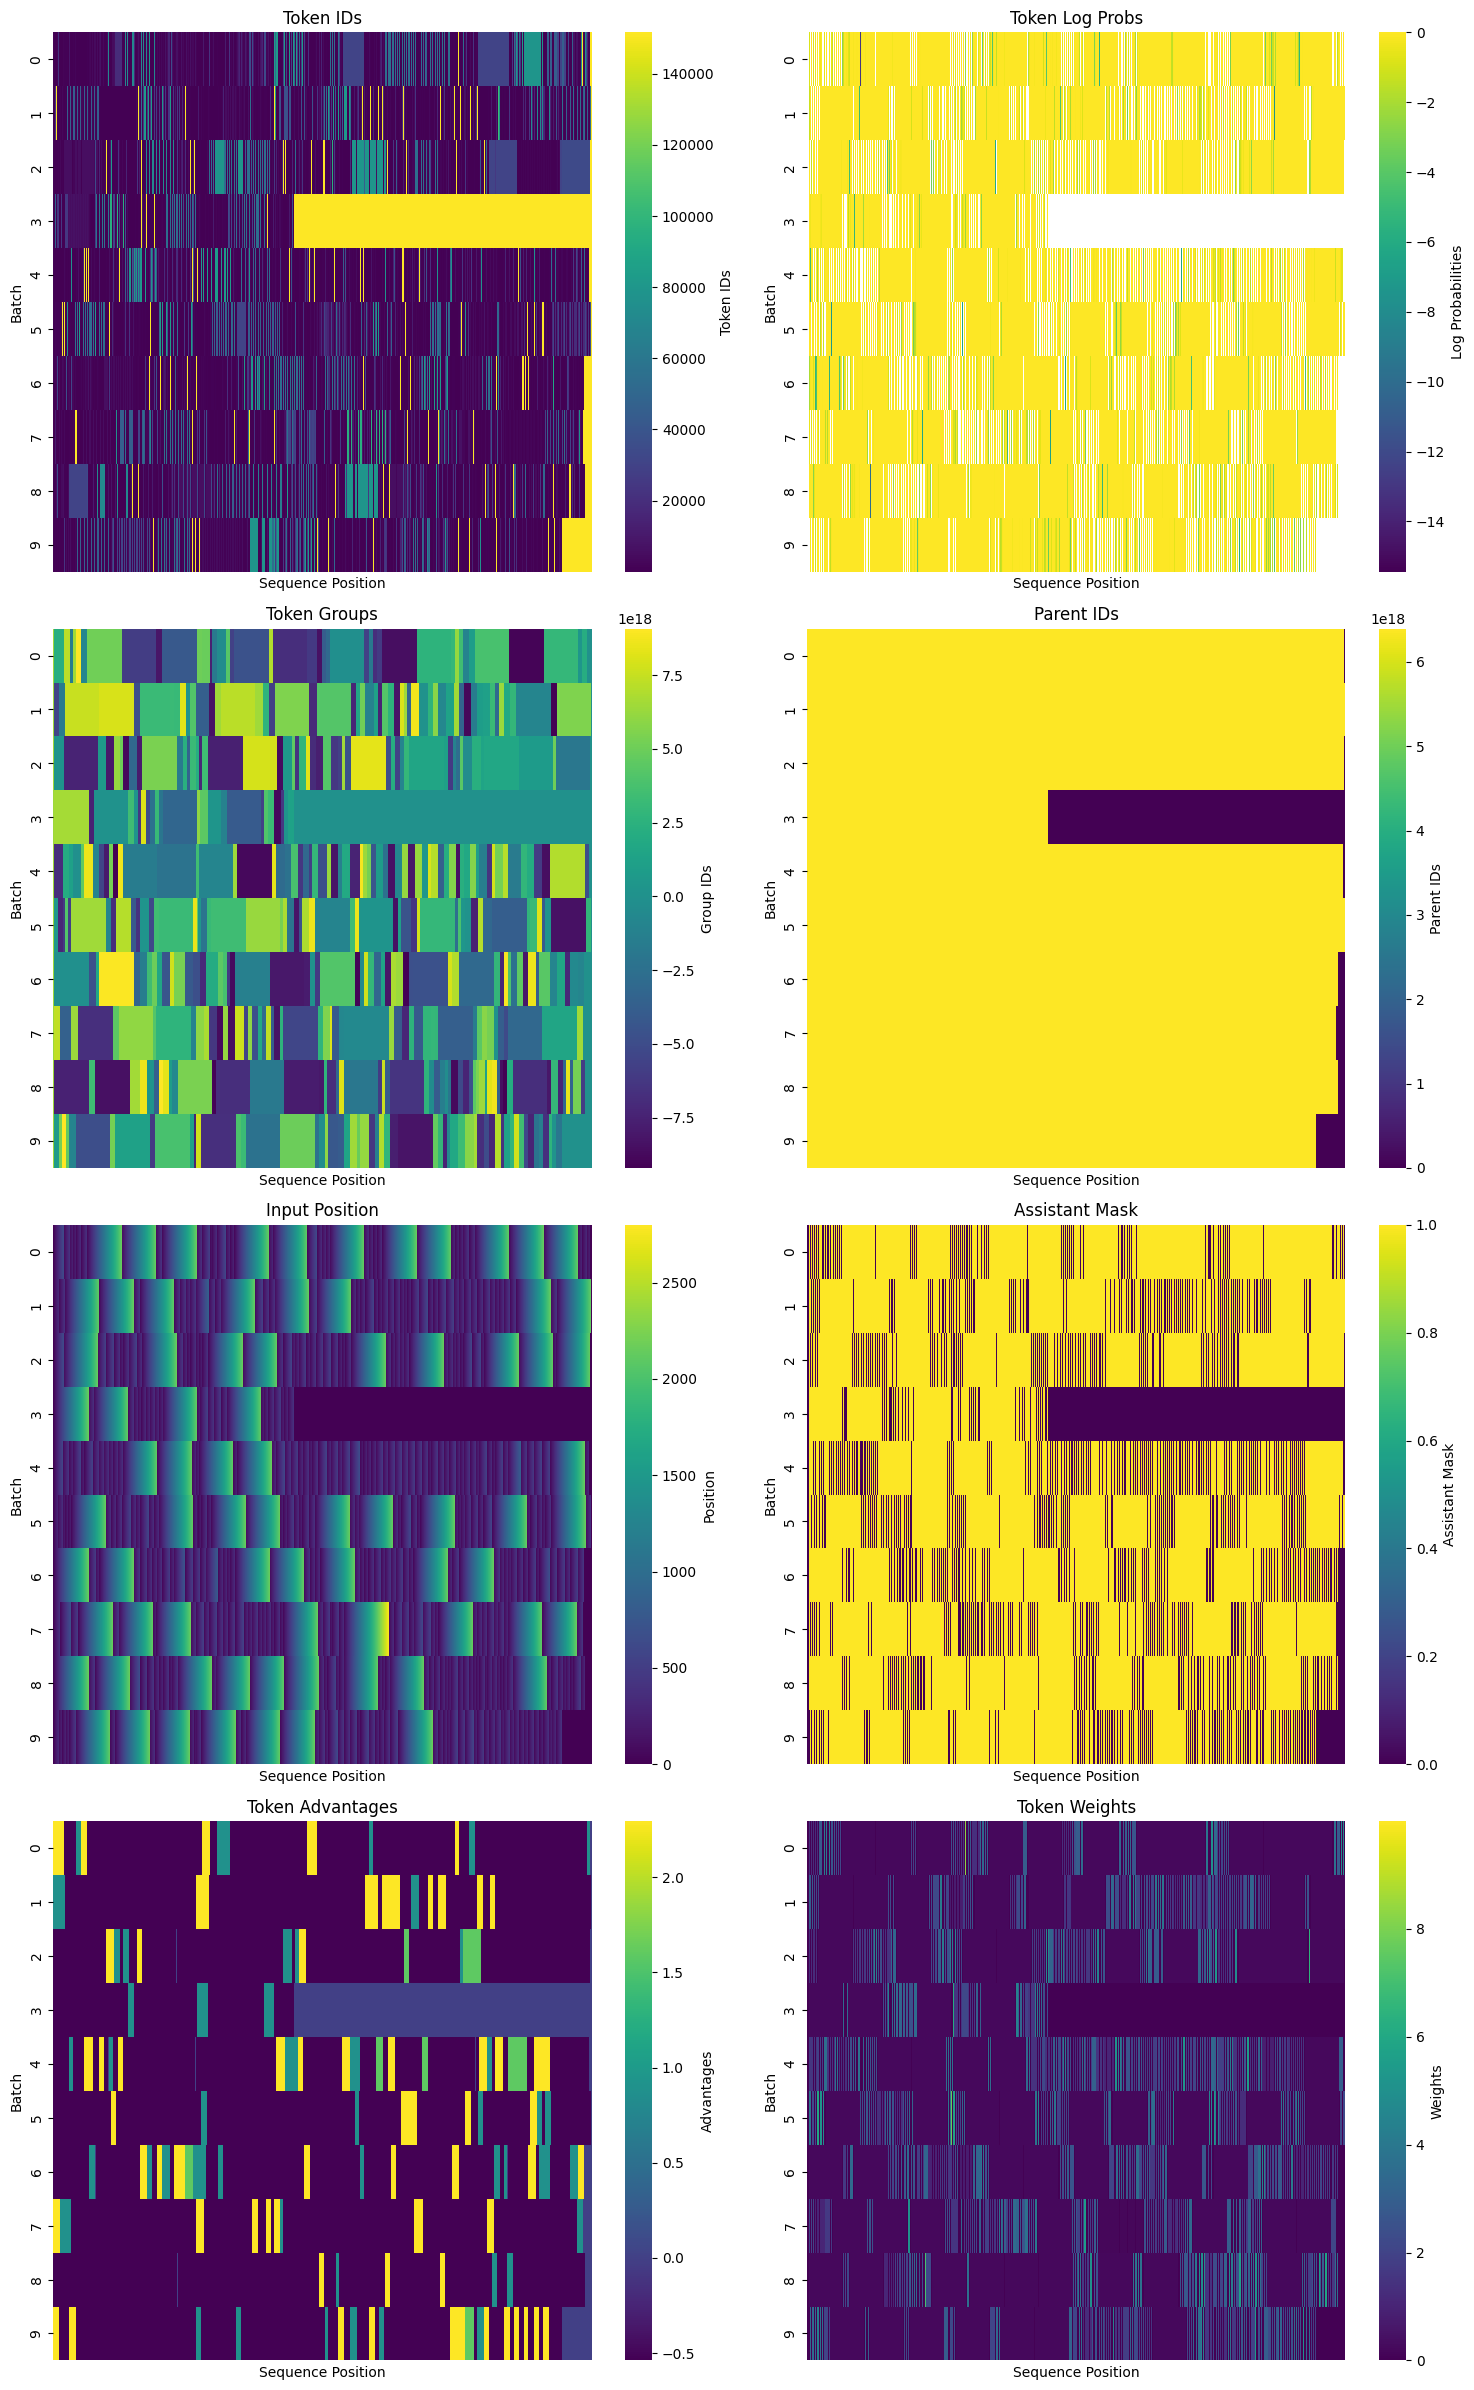

tune:   0%|          | 0/10 [00:00<?, ?it/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 3 | Total steps = 300,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 1 x 1) = 2
 "-____-"     Trainable parameters = 20,185,088/7,000,000,000 (0.29% trained)


Unsloth: Will smartly offload gradients to save VRAM!


train:   0%|          | 0/512 [00:00<?, ?it/s]

invalid literal for int() with base 10: 'm'
string index out of range
string index out of range
string index out of range
string index out of range
string index out of range
string index out of range
string index out of range
string index out of range
invalid literal for int() with base 10: 'o'
invalid literal for int() with base 10: '/'
string index out of range
string index out of range
invalid literal for int() with base 10: '/'
invalid literal for int() with base 10: '/'
string index out of range
invalid literal for int() with base 10: '/'
string index out of range
invalid literal for int() with base 10: 'o'
string index out of range
string index out of range
string index out of range
invalid literal for int() with base 10: 'h'
invalid literal for int() with base 10: 'n'
invalid literal for int() with base 10: 'o'
invalid literal for int() with base 10: 'p'
string index out of range
string index out of range
string index out of range
invalid literal for int() with base 10: '/'
Dele

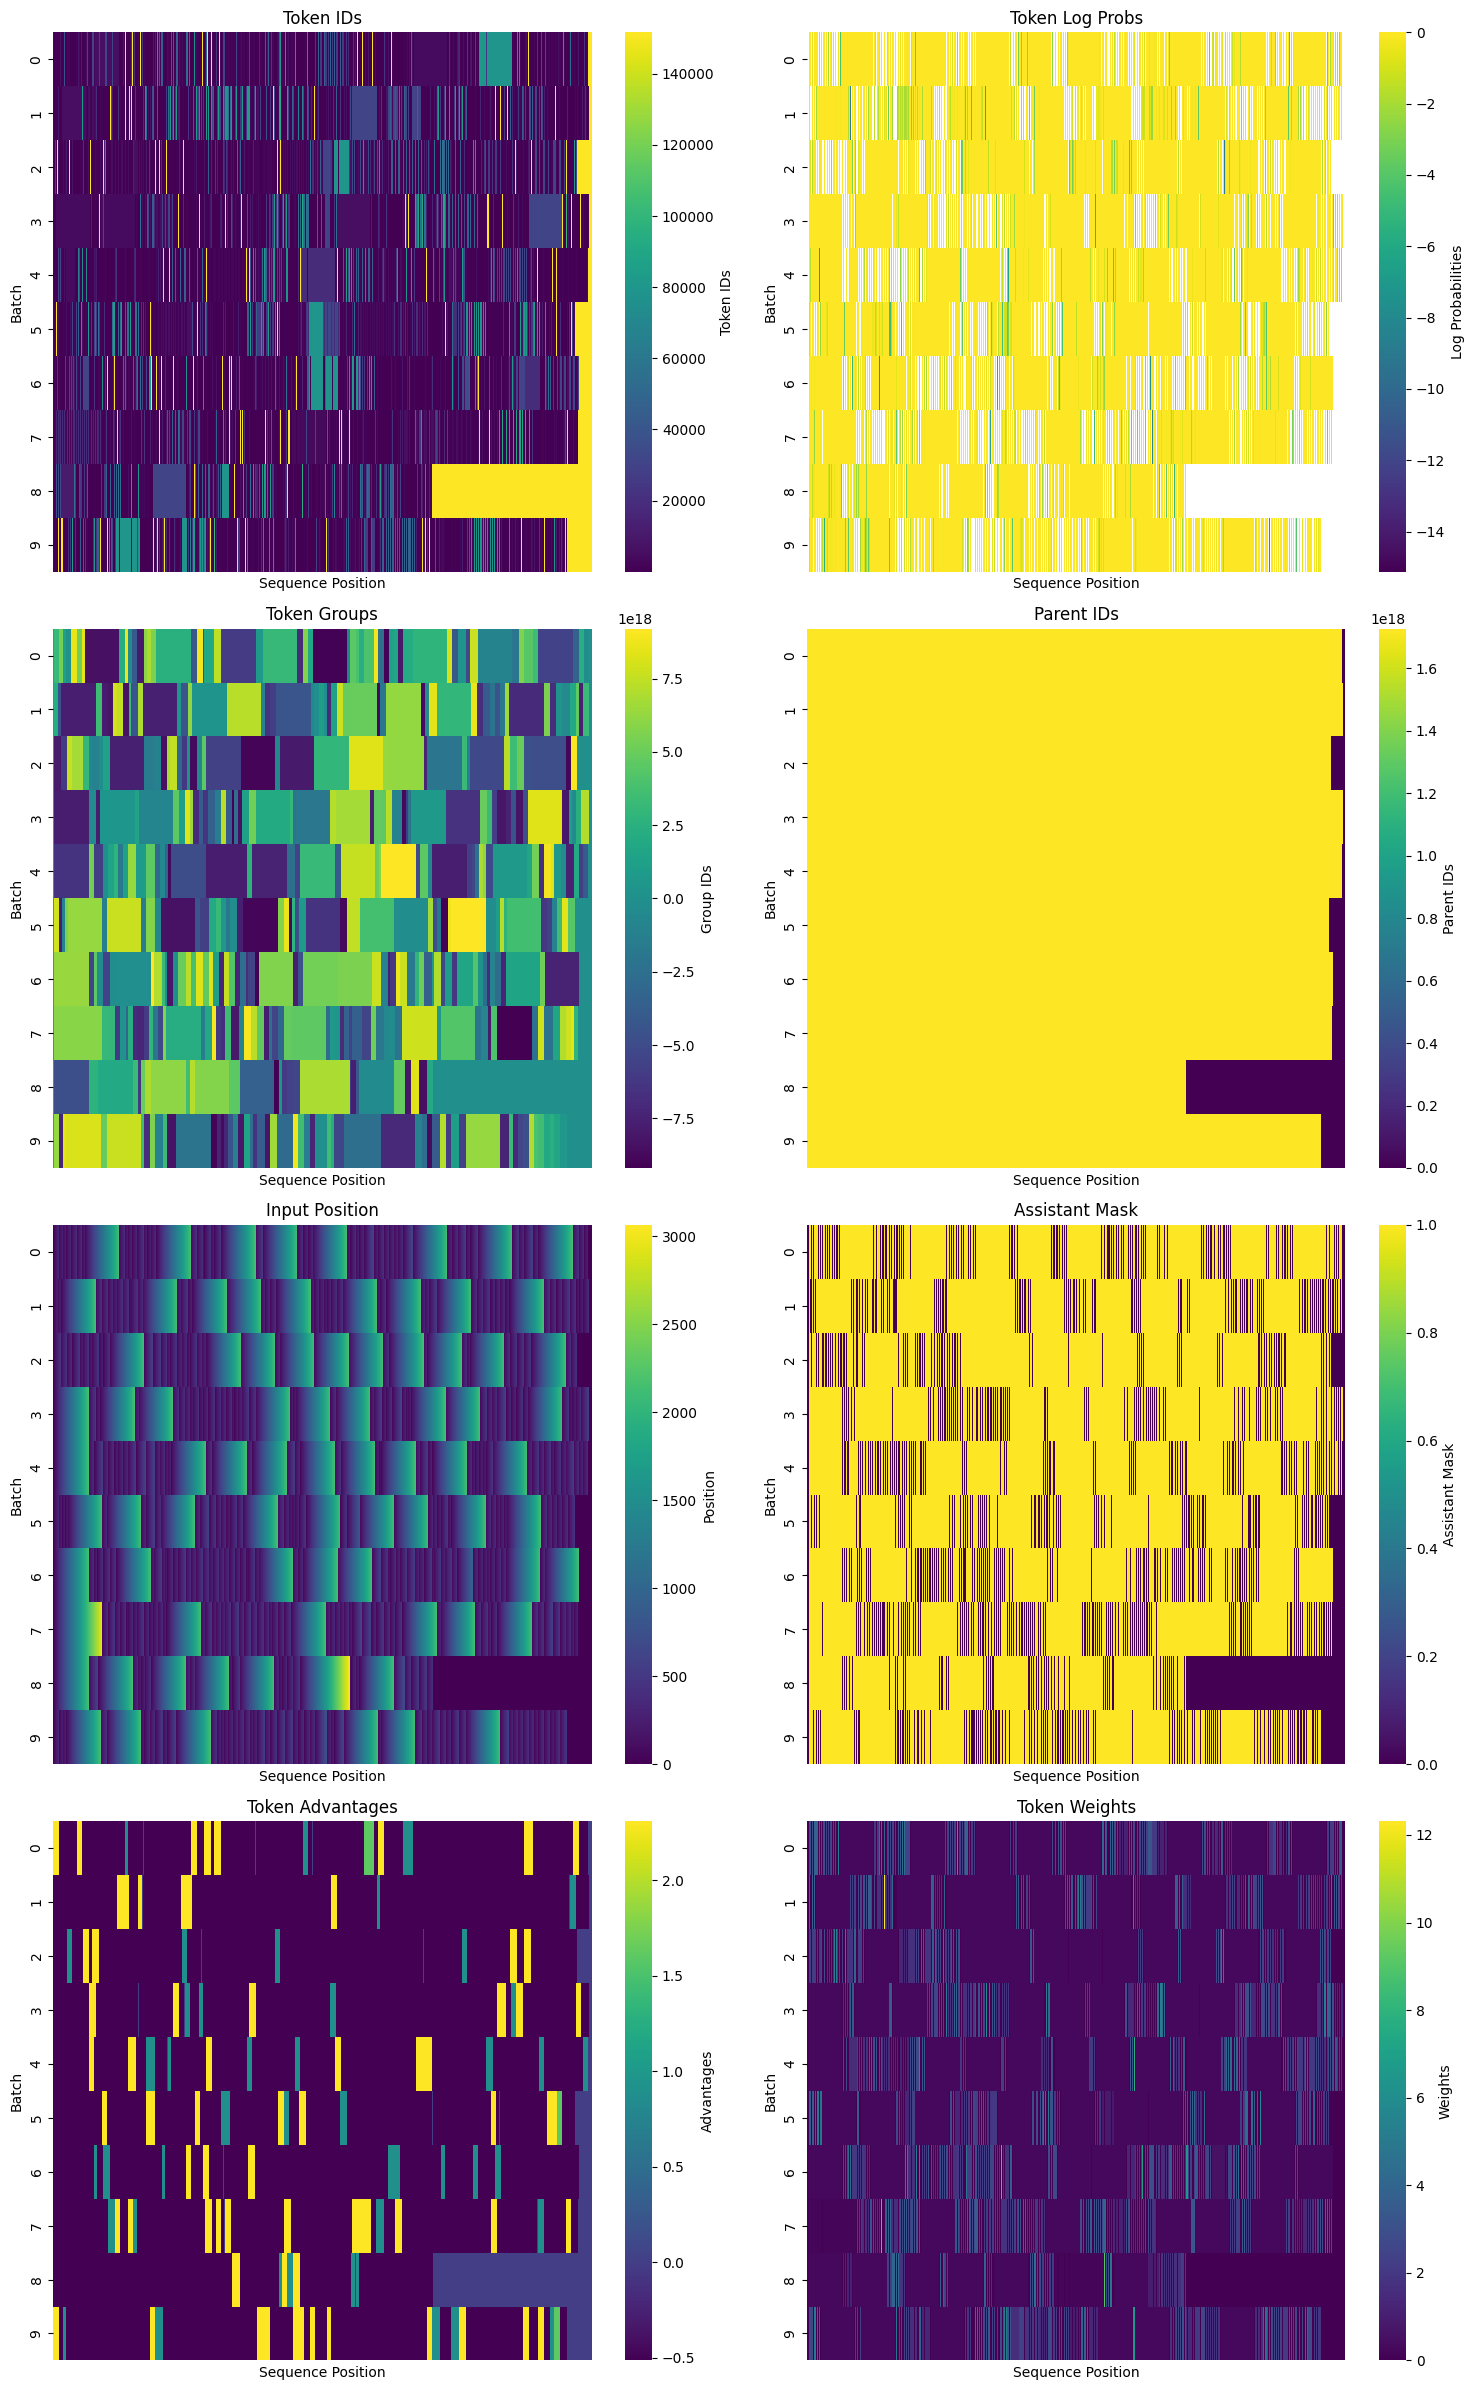

tune:   0%|          | 0/10 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

invalid literal for int() with base 10: 'o'
invalid literal for int() with base 10: 'o'
string index out of range
invalid literal for int() with base 10: '/'
Deleted iteration directory ./.art/models/tic-tac-toe-007/0001


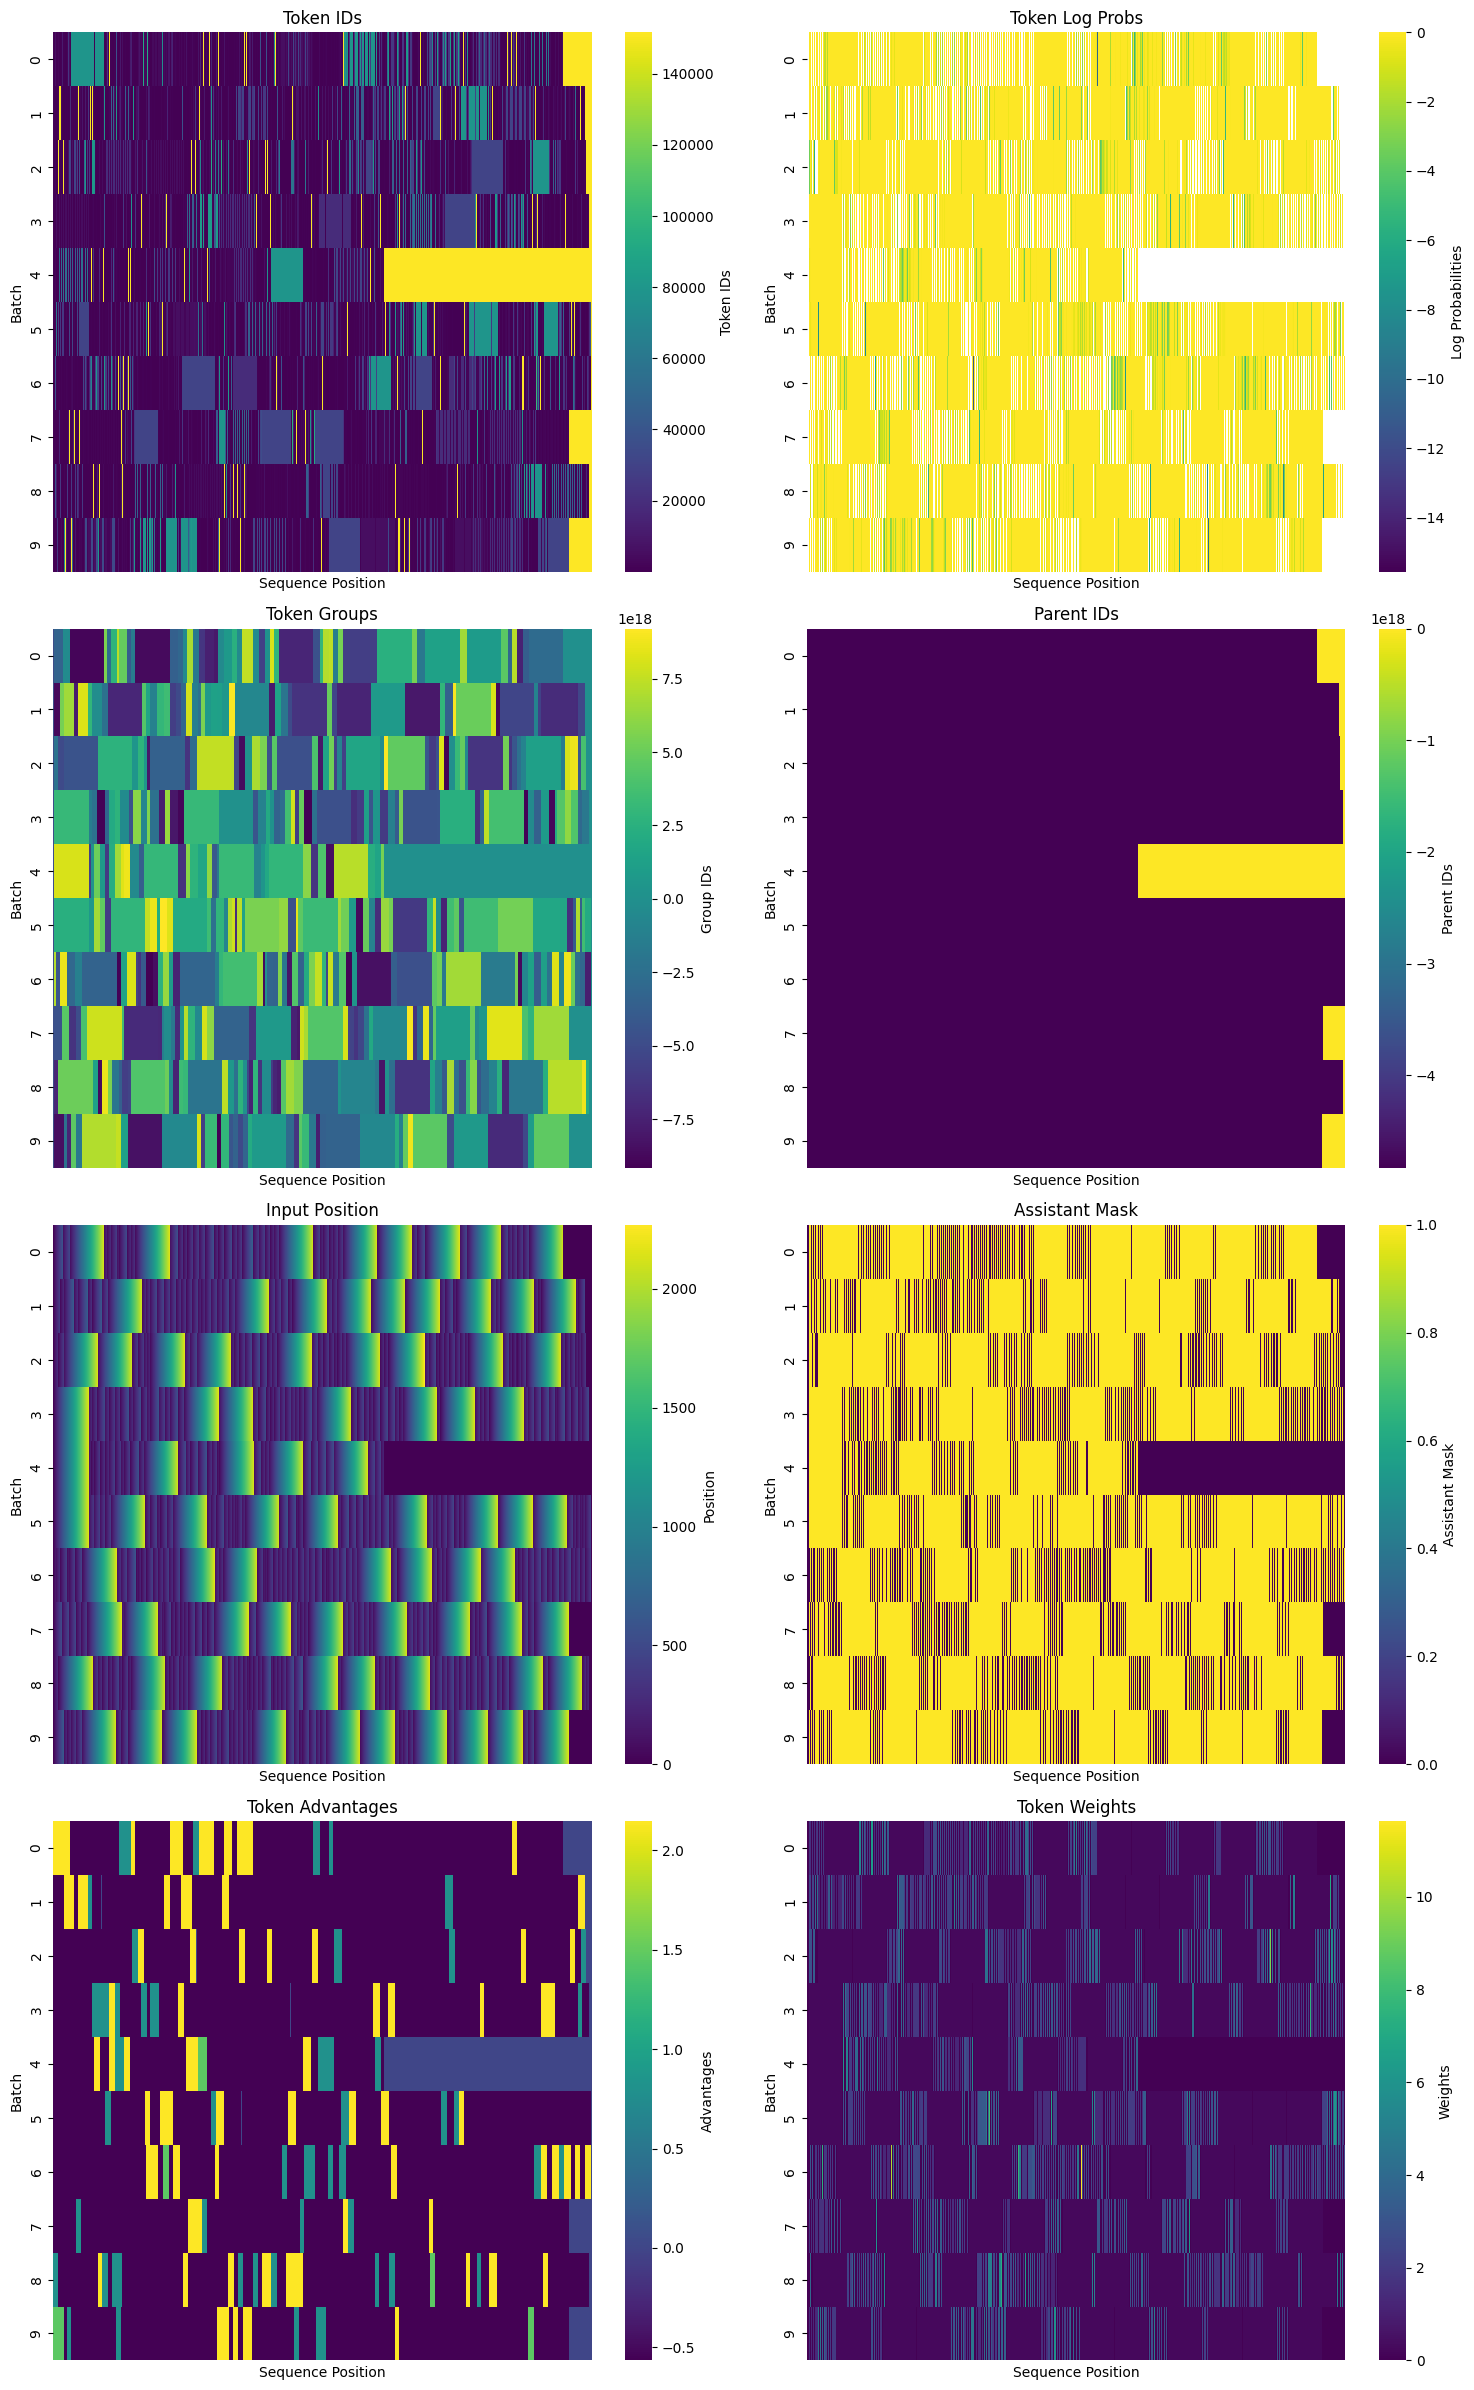

tune:   0%|          | 0/10 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

invalid literal for int() with base 10: 'c'
caught exception generating chat completion
Request timed out.
caught exception generating chat completion
Request timed out.


APITimeoutError: Request timed out.

caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught exception generating chat completion
Connection error.
caught e

In [4]:
import art
import asyncio
from dotenv import load_dotenv
import json
import openai
import random
from typing import TypedDict
from openpipe.client import OpenPipe
import time
from typing import Literal
from pydantic import BaseModel

load_dotenv()


class TicTacToeGame(TypedDict):
    board: list[list[str]]
    agent_symbol: Literal["x", "o"]
    opponent_symbol: Literal["x", "o"]


def generate_game(board_length: int = 3) -> TicTacToeGame:
    board = [["_" for _ in range(board_length)] for _ in range(board_length)]
    agent_symbol = random.choice(["x", "o"])
    opponent_symbol = "x" if agent_symbol == "o" else "o"
    return {
        "board": board,
        "agent_symbol": agent_symbol,
        "opponent_symbol": opponent_symbol,
    }


def render_board(game: TicTacToeGame) -> str:
    board = game["board"]
    board_length = len(board)
    # print something like this:
    #    1   2   3
    # A  _ | x | x
    # B  o | _ | _
    # C  _ | o | _
    # where _ is an empty cell

    board_str = "   " + "   ".join([str(i + 1) for i in range(board_length)]) + "\n"
    for i in range(board_length):
        board_str += f"{chr(65 + i)}  {board[i][0]} | {board[i][1]} | {board[i][2]}\n"
    return board_str


def get_opponent_move(game: TicTacToeGame) -> tuple[int, int]:
    # get a random empty cell
    empty_cells = [
        (i, j) for i in range(3) for j in range(3) if game["board"][i][j] == "_"
    ]
    return random.choice(empty_cells)


class AgentMove(BaseModel):
    reason: str
    square: str


def apply_agent_move(game: TicTacToeGame, move: str) -> None:
    board_length = len(game["board"])
    json_move = json.loads(move)
    square = json_move["square"]

    try:
        row_index = ord(square[0]) - 65
        col_index = int(square[1]) - 1
    except Exception as e:
        print(e)
        raise ValueError("Unable to parse square")

    if (
        row_index < 0
        or row_index >= board_length
        or col_index < 0
        or col_index >= board_length
    ):
        raise ValueError(
            f"Invalid move, row or column out of bounds: {row_index}, {col_index}"
        )

    # check if the move is valid
    if game["board"][row_index][col_index] != "_":
        raise ValueError("Square already occupied")

    game["board"][row_index][col_index] = game["agent_symbol"]


def check_winner(board: list[list[str]]) -> Literal["x", "o", "draw", None]:
    board_length = len(board)
    # check rows
    for row in board:
        if row.count(row[0]) == board_length and row[0] != "_":
            return row[0]
    # check columns
    for col in range(board_length):
        if [board[row][col] for row in range(board_length)].count(
            board[0][col]
        ) == board_length and board[0][col] != "_":
            return board[0][col]

    # top right to bottom left
    upward_diagonal = [board[i][board_length - i - 1] for i in range(board_length)]
    if (
        upward_diagonal.count(upward_diagonal[0]) == board_length
        and upward_diagonal[0] != "_"
    ):
        return upward_diagonal[0]

    # top left to bottom right
    downward_diagonal = [board[i][i] for i in range(board_length)]
    if (
        downward_diagonal.count(downward_diagonal[0]) == board_length
        and downward_diagonal[0] != "_"
    ):
        return downward_diagonal[0]

    # check for draw
    if all(cell != "_" for row in board for cell in row):
        return "draw"
    return None


def get_trajectory_messages(trajectory: art.Trajectory) -> art.Messages:
    messages: art.Messages = []
    for item in trajectory.messages_and_choices:

        # if item is not a dict, convert it to a dict
        if not isinstance(item, dict):
            item = item.to_dict()

        # check if item is a choice
        if "message" in item:
            messages.append(
                {"role": "assistant", "content": item["message"]["content"]}
            )
        else:
            # otherwise it's a message
            messages.append(item)
    return messages


failing_trajectory = None


@art.retry(exceptions=(openai.LengthFinishReasonError,))
async def rollout(
    client: openai.AsyncOpenAI, iteration: int, is_validation: bool
) -> art.Trajectory:

    game = generate_game()

    trajectory = art.Trajectory(
        messages_and_choices=[
            {
                "role": "system",
                "content": f"You are a tic-tac-toe player. You are playing against an opponent. Always choose the move most likely to lead to an eventual win. Return the move in the format 'A1', 'B2', 'C3', etc. You are the {game['agent_symbol']} symbol.",
            }
        ],
        reward=0,
        metrics={"test": 5},
    )

    if game["agent_symbol"] == "o":
        starting_opponent_move = get_opponent_move(game)
        game["board"][starting_opponent_move[0]][starting_opponent_move[1]] = game[
            "opponent_symbol"
        ]


    while check_winner(game["board"]) is None:

        trajectory.messages_and_choices.append(
            {"role": "user", "content": render_board(game)}
        )

        requested_at = int(time.time() * 1000)
        messages = get_trajectory_messages(trajectory)

        async def get_completion():
            return await client.chat.completions.create(
                max_completion_tokens=2048,
                messages=messages,
                model=model.name,
                extra_body={"guided_json": AgentMove.model_json_schema()},
            )

        try:
            chat_completion = await get_completion()
            last_completion = chat_completion
        except openai.LengthFinishReasonError as e:
            raise e
        except Exception as e:
            print("caught exception generating chat completion")
            print(e)
            global failing_trajectory
            failing_trajectory = trajectory
            raise e

        try:
            op_client.report(
                requested_at=requested_at,
                received_at=int(time.time() * 1000),
                req_payload={
                    "model": model.name,
                    "messages": messages,
                    "metadata": {
                        "notebook-id": "tic-tac-toe",
                        "iteration": str(iteration),
                        "validation": str(is_validation),
                        "move_number": str(len(trajectory.messages_and_choices) - 1),
                    },
                },
                resp_payload=chat_completion,
                status_code=200,
            )
        except Exception as e:
            print(f"Error reporting to OpenPipe: {e}")

        choice = chat_completion.choices[0]
        content = choice.message.content
        assert isinstance(content, str)
        trajectory.messages_and_choices.append(choice)

        try:
            apply_agent_move(game, content)
        except ValueError as e:
            trajectory.reward = -1
            break

        if check_winner(game["board"]) is not None:
            break

        opponent_move = get_opponent_move(game)
        game["board"][opponent_move[0]][opponent_move[1]] = game["opponent_symbol"]

    winner = check_winner(game["board"])

    if winner == game["agent_symbol"]:
        trajectory.reward = 1
    elif winner == game["opponent_symbol"]:
        trajectory.reward = 0
    elif winner == "draw":
        trajectory.reward = 0.5

    try:
        op_client.update_log_metadata(
            filters=[
                {
                    "field": "completionId",
                    "equals": last_completion.id,
                }
            ],
            metadata={
                "reward": str(trajectory.reward),
                "reward_assigned": "true",
            }
        )
    except Exception as e:
        print(f"Error updating log metadata: {e}")

    return trajectory


for i in range(await model.get_iteration(), 50):
    async with model.openai_client(
        estimated_completion_tokens=100, verbosity=2
    ) as openai_client:
        train_groups = await art.gather_trajectories(
                (
                    (rollout(openai_client, i, is_validation=False) for _ in range(512))
                    for _ in range(1)
                ),
                pbar_desc="train",
                return_exceptions=False,
            )
    await model.clear_iterations()
    await model.tune(
        train_groups, config=art.TuneConfig(plot_tensors=True, verbosity=2, lr=1e-4, kl_coef=0.04, sequence_length=32768)
    )